# Sentencing

In [1]:
import os
from lib.words import not_so_naive_split, replace_evil_dots_and_underscores
from lib.parallel_run import parallel_run
import numpy as np

Divisione del testo in frasi, rimozione di stop words, numeri, punteggiatura...

In [5]:
# Esempio di split

t = not_so_naive_split(text, split='.')
#t

In [2]:
def sentence_splitting(src_dir, out_dir, digit_replacement='NUM', split='.', min_words=2, max_n=-1):
    i = 0
    for f in os.listdir(src_dir):
        txt = open(src_dir+'/'+f).read()
        splitted = not_so_naive_split(txt, digit_replacement, split, min_words)
        with open(out_dir+'/'+f, 'w') as of:
            for l in splitted:
                of.write(' '.join(l)+'\n')
        if max_n>0 and i >= max_n:
            break
        i += 1

In [15]:
# Per atti costitutivi
sentence_splitting('../atti_costitutivi_txt','../atti_costitutivi_sentences')

In [3]:
# Per atti non costitutivi
sentence_splitting('../atti_non_costitutivi_txt2','../atti_non_costitutivi_sentences')

In [4]:
# Per atti non costitutivi scansionati
sentence_splitting('../ocr/scanned_non_costitutivi','../atti_non_costitutivi_sentences')

In [3]:
# Esempio di testo elaborato

text = open('../atti_non_costitutivi_sentences/'+'4578843770001.txt').read()
print text

## Conversione in CSV

In [5]:
def folders_to_csv(csv_file, dirs, labels):
    '''
    Writes to a csv file the lines contained in a list of directories,
    assuming each directory is associated to one label'''
    with open(csv_file,'w') as out_file:
        out_file.write('filename,sentence,label\n')
        for d, label in zip(dirs, labels):
            for f in os.listdir(d):
                with open(d+'/'+f) as in_file:
                    for line in in_file:
                        out_file.write((','.join([f[:-4],line.strip(),label]))+'\n')
 

In [7]:
folders_to_csv('../atti.csv', ['../atti_costitutivi_sentences/', '../atti_non_costitutivi_sentences/'], ['costitutivo','non_costitutivo'])

## Statistiche PANDAS

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

In [31]:
def print_column_stats(col):
    print 'Mean', col.mean()
    print 'Stddev', col.std()
    print 'Min', col.min()
    print 'Max', col.max()

In [4]:
df = pd.read_csv("../atti.csv")
#df

In [20]:
df_nc = df.loc[df['label'] == 'non_costitutivo']
df_c = df.loc[df['label'] == 'costitutivo']

## Distribuzione numero parole per linea

In [5]:
s_len = df['sentence'].apply(lambda s:len(s.split()))

In [34]:
print_column_stats(s_len)

Mean 26.874290118
Stddev 41.410598666
Min 2
Max 8326


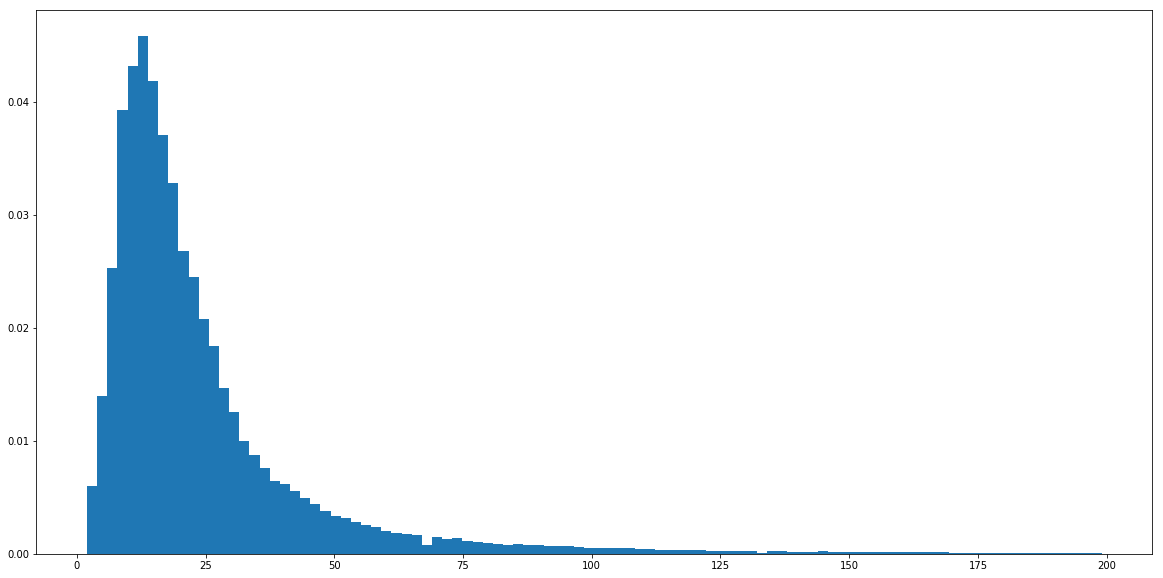

In [7]:
plt.figure(figsize=(20,10))
plt.hist([s for s in s_len if s<200], bins=100, normed=True)
#plt.yscale('log', nonposy='clip')
plt.show()

In [24]:
s_len_c = df_c['sentence'].apply(lambda s:len(s.split()))
s_len_nc = df_nc['sentence'].apply(lambda s:len(s.split()))

In [35]:
print_column_stats(lines_per_file_c)
print_column_stats(lines_per_file_nc)

Mean 69.0195319201
Stddev 67.5761083838
Min 1
Max 516
Mean 17.8330113166
Stddev 19.6865567514
Min 1
Max 721


In [26]:
def hist_len(s_len):
    plt.figure(figsize=(20,10))
    plt.hist([s for s in s_len if s<200], bins=100, normed=True)
    #plt.yscale('log', nonposy='clip')
    plt.show()

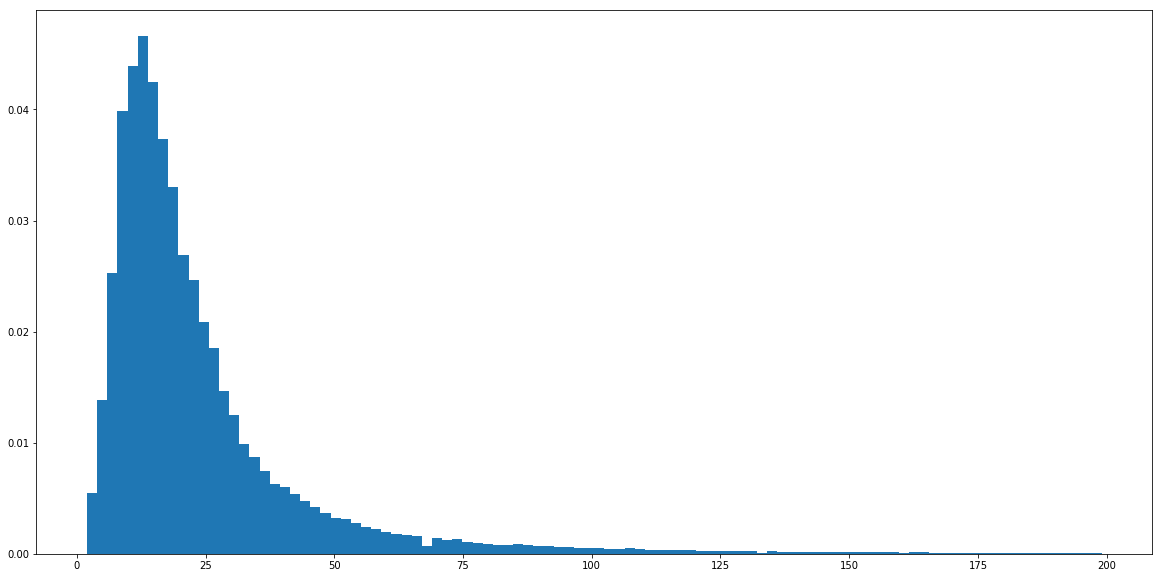

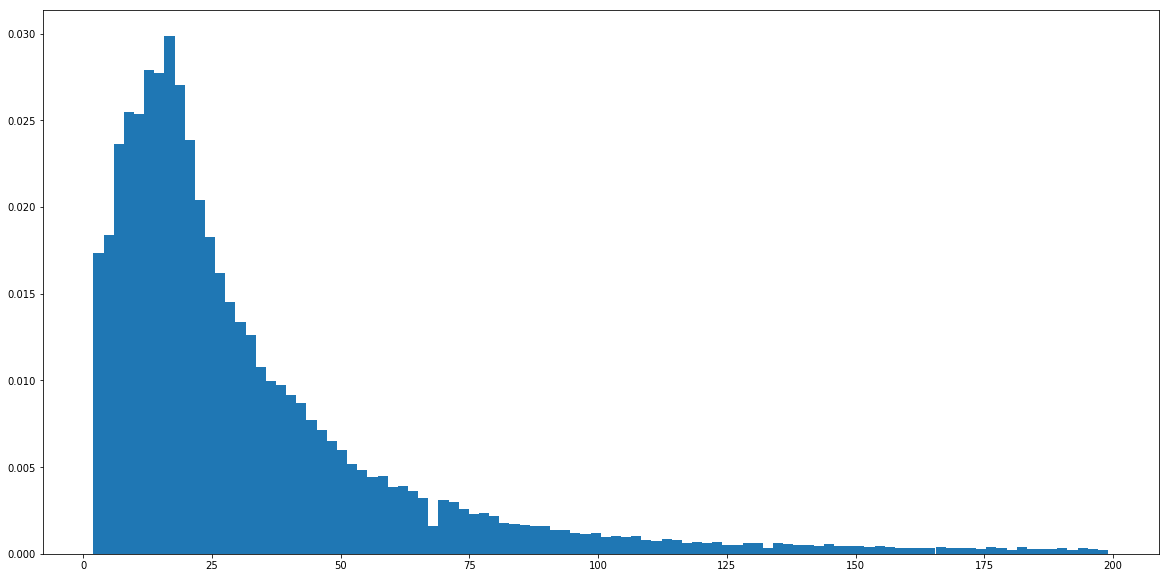

In [27]:
hist_len(s_len_c)
hist_len(s_len_nc)

## Distribuzione numero linee per file

In [12]:
lines_per_file = df[['filename','sentence']].groupby(['filename']).size()

In [32]:
print_column_stats(lines_per_file)

Mean 61.3007013382
Stddev 65.3594308112
Min 1
Max 721


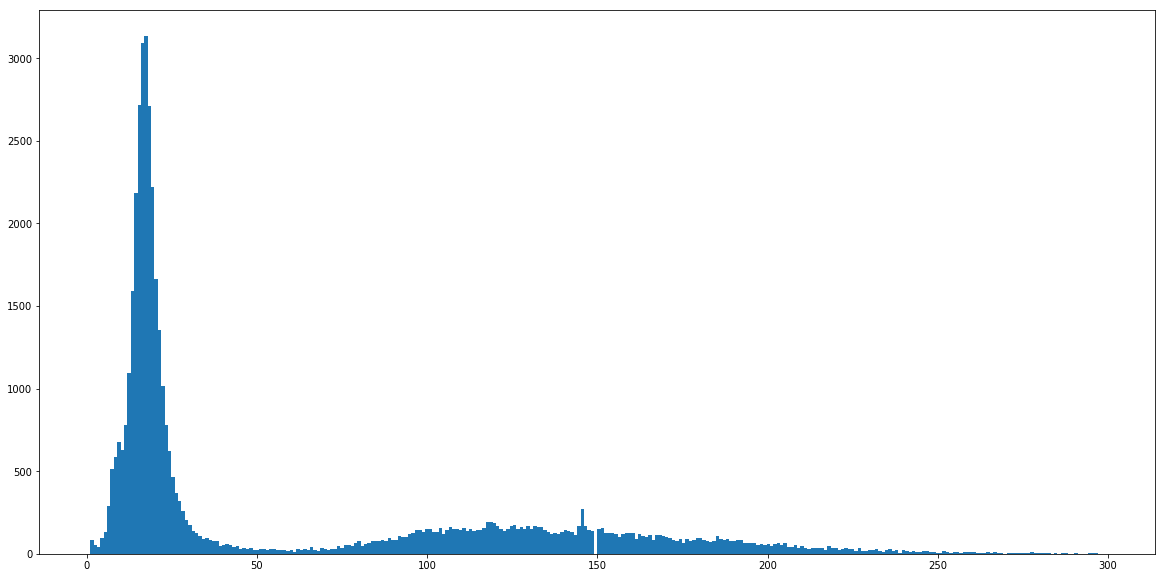

In [19]:
plt.figure(figsize=(20,10))
plt.hist([l for l in lines_per_file if l<300], bins=300)
#plt.yscale('log', nonposy='clip')
plt.show()

In [21]:
lines_per_file_nc = df_nc[['filename','sentence']].groupby(['filename']).size()
lines_per_file_c = df_c[['filename','sentence']].groupby(['filename']).size()

In [33]:
print_column_stats(lines_per_file_c)
print_column_stats(lines_per_file_nc)

Mean 69.0195319201
Stddev 67.5761083838
Min 1
Max 516
Mean 17.8330113166
Stddev 19.6865567514
Min 1
Max 721


In [22]:
def hist_lines(lines):
    plt.figure(figsize=(20,10))
    plt.hist([l for l in lines if l<300], bins=300)
    #plt.yscale('log', nonposy='clip')
    plt.show()

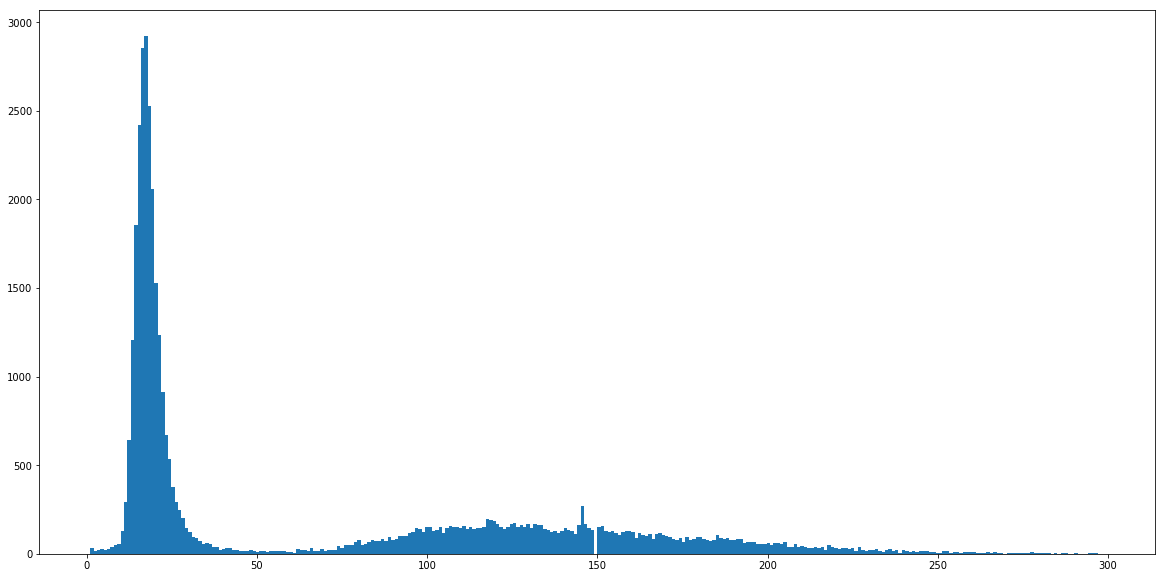

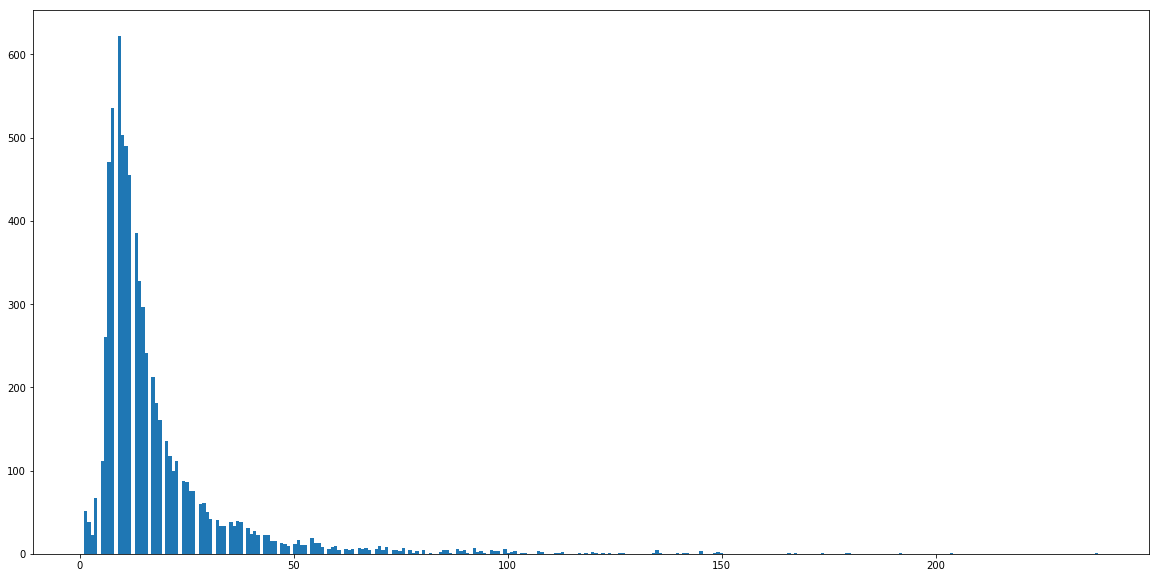

In [23]:
hist_lines(lines_per_file_c)
hist_lines(lines_per_file_nc)

## NLTK test

In [2]:
import nltk
from nltk.tokenize import WordPunctTokenizer
tokenizer = nltk.data.load('tokenizers/punkt/italian.pickle')
word_tokenizer = WordPunctTokenizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('italian'))

In [16]:
def replace_num(word, num_repl='NUM'):
    return num_repl if word.isdigit() else word

def tokenize_doc(doc, min_words=2):
    txt = replace_evil_dots_and_underscores(doc)
    #print txt
    sents = tokenizer.sentences_from_text(txt)
    sents_words = word_tokenizer.tokenize_sents(sents)
    splitted_sents = []
    #print splitted_sents
    for sentence in sents_words:
        sent = [replace_num(word) for word in sentence if word.isalnum() and word not in stop_words]
        if len(sent)>=min_words:
            splitted_sents.append(sent)
    return splitted_sents

In [20]:
s = 'ciao\n\n\n. eravamo in sei come va? questa è una super S.P.A. frase ART. 1 1223. molto bene\n ciao\n muahah\n\n.'
print tokenize_doc(s,2)

[['ciao'], ['va'], ['super', 'SPA', 'frase', 'ART', 'NUM', 'NUM', 'molto', 'bene', 'ciao', 'muahah']]


In [21]:
not_so_naive_split(s, min_words=1)

[['ciao'],
 ['super', 'spa', 'frase', 'art', 'NUM', 'NUM'],
 ['bene', 'ciao', 'muahah']]